# Stroke Prognosis: Utilización y evaluación de los Modelos

<p>
Curso de Minería de Datos <br>
Autor: Cristian Pavez Hormazábal
</p>
Queda pendiente KNN
</p>

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import lightgbm as lg
import xgboost as xgb

# Importación de datos
dataset = pd.read_csv("all-data.csv")

In [ ]:
formated_dataset = dataset.drop('id', axis=1)
formated_dataset['gender'] = formated_dataset['gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
formated_dataset['ever_married'] = formated_dataset['ever_married'].map({'Yes': 1, 'No': 0})
formated_dataset['work_type'] = formated_dataset['work_type'].map({'Private': 4, 'Self-employed': 2, 'Govt_job': 3, 'children': 1, 'Never_worked': 0})
formated_dataset['Residence_type'] = formated_dataset['Residence_type'].map({'Rural': 0, 'Urban': 1})
formated_dataset['smoking_status'] = formated_dataset['smoking_status'].map({'Unknown': 0, 'never smoked': 1, 'formerly smoked': 2, 'smokes': 3})
formated_dataset['stroke'] = formated_dataset['stroke'].map({1: 0, 0: 1})

models = {
    "Decision Tree": sk.tree.DecisionTreeClassifier(),
    "Gaussian Naive Bayes": sk.naive_bayes.GaussianNB(),   # En el test no salió bueno
    "Bernoulli Naive Bayes": sk.naive_bayes.BernoulliNB(), # En el test no salió bueno
    "SVM": sk.svm.SVC(probability=True),                   # En el test no salió bueno
    "Random Forest": sk.ensemble.RandomForestClassifier(),
    "KNN": sk.neighbors.KNeighborsClassifier(n_neighbors=5),
    #"XGB": xgb.XGBClassifier(random_state=42),
    #"LGBM": lg.LGBMClassifier(random_state=42),
    #"ExtraTrees": sk.ensemble.ExtraTreesClassifier(n_estimators=100, random_state=42),
    #"Bagging ExtraTrees": sk.ensemble.BaggingClassifier(estimator=sk.ensemble.ExtraTreesClassifier(n_estimators=100, random_state=42), n_estimators=50, random_state=42)
}

def entrenar(x, y):
    all_results = []
    for name, model in models.items():
        results = []
        for i in range(5):
            x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size=0.2, random_state=i)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            # Obtener probabilidades o scores para ROC
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(x_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(x_test)
            else:
                y_score = None
            cm = sk.metrics.confusion_matrix(y_test, y_pred)
            acc = sk.metrics.accuracy_score(y_test, y_pred)
            prec = sk.metrics.precision_score(y_test, y_pred)
            rec = sk.metrics.recall_score(y_test, y_pred)
            f1 = sk.metrics.f1_score(y_test, y_pred)
            results.append({
                "confusion_matrix": cm,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1_score": f1,
                "y_test": y_test,
                "y_score": y_score
            })
        all_results.append({f"{name}": results})
        if name == "Decision Tree":
            plt.figure(figsize=(20, 10))
            sk.tree.plot_tree(model, feature_names=x.columns, class_names=['No Stroke', 'Stroke'], filled=True, rounded=True, fontsize=10)
            plt.title("Estructura del Árbol de Decisión")
            plt.show()
    return all_results
    
def graficar_resultados(all_results):
    for model in all_results:
        name, results = list(model.items())[0]
        cms = [r['confusion_matrix'] for r in results]
        tps = [cm[0][0] for cm in cms]
        fns = [cm[0][1] for cm in cms]
        fps = [cm[1][0] for cm in cms]
        tns = [cm[1][1] for cm in cms]
        accs = [r['accuracy'] for r in results]
        precs = [r['precision'] for r in results]
        recs = [r['recall'] for r in results]
        f1s = [r['f1_score'] for r in results]

        # Crear boxplot de las métricas
        data = [accs, precs, recs, f1s]
        labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        plt.figure(figsize=(8, 6))
        plt.boxplot(data, tick_labels=labels)
        plt.title(f'Boxplot de métricas para {name}')
        plt.ylabel('Score')
        plt.ylim(0, 1) 
        plt.grid(True)
        plt.show()

        # Matriz de confusión promedio
        avg_cm = np.array([
            [np.mean(tps), np.mean(fns)],
            [np.mean(fps), np.mean(tns)]
        ])
        plt.figure(figsize=(4, 4))
        sns.heatmap(avg_cm, annot=True, fmt=".1f", cmap="Blues", xticklabels=["Pred. Stroke", "Pred. no Stroke"], yticklabels=["Real Stroke", "Real no Stroke"])
        plt.title(f'Matriz de confusión promedio para {name}')
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()

        # Curva ROC
        from sklearn.metrics import roc_curve, auc
        # Curva ROC promedio
        fpr_list = []
        tpr_list = []
        auc_list = []
        for r in results:
            # Verifica si el modelo tiene predict_proba o decision_function
            try:
                y_score = r.get('y_score', None)
                if y_score is not None:
                    fpr, tpr, _ = roc_curve(r['y_test'], y_score)
                    fpr_list.append(fpr)
                    tpr_list.append(tpr)
                    auc_list.append(auc(fpr, tpr))
            except Exception as e:
                continue

        if fpr_list and tpr_list:
            plt.figure(figsize=(6, 6))
            for i, (fpr, tpr) in enumerate(zip(fpr_list, tpr_list)):
                plt.plot(fpr, tpr, alpha=0.3, label=f'ROC split {i+1}')
            mean_auc = np.mean(auc_list)
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Curvas ROC solapadas para {name}\n(AUC promedio = {mean_auc:.2f})')
            plt.legend(loc='lower right', fontsize='small', ncol=2)
            plt.grid(True)
            plt.show()        

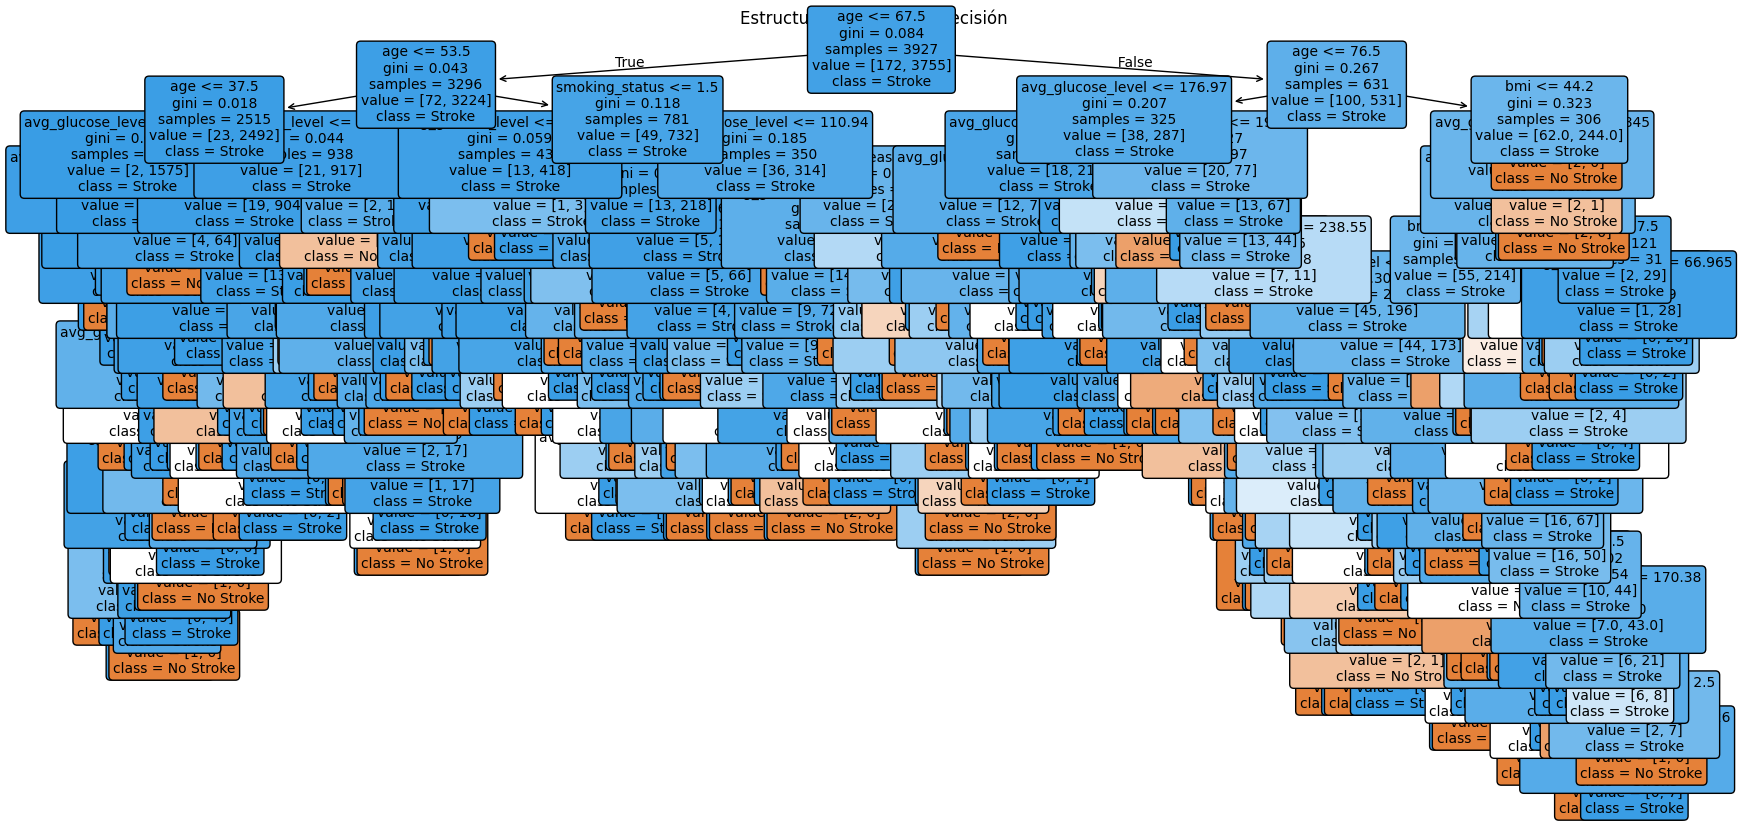

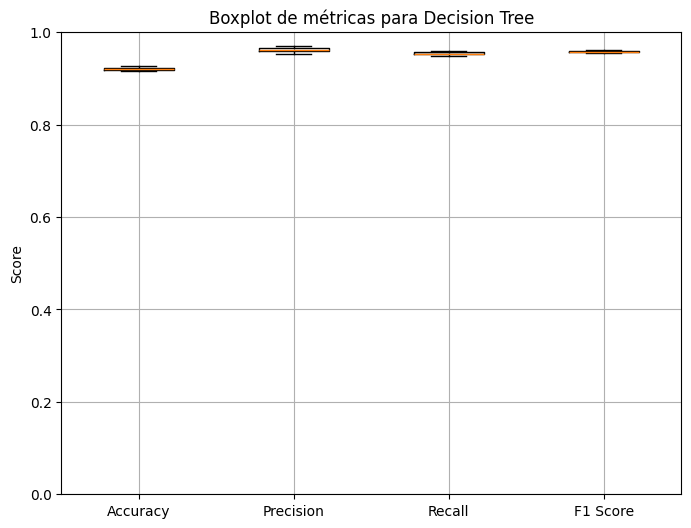

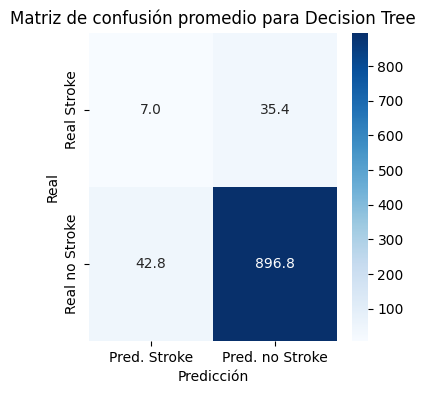

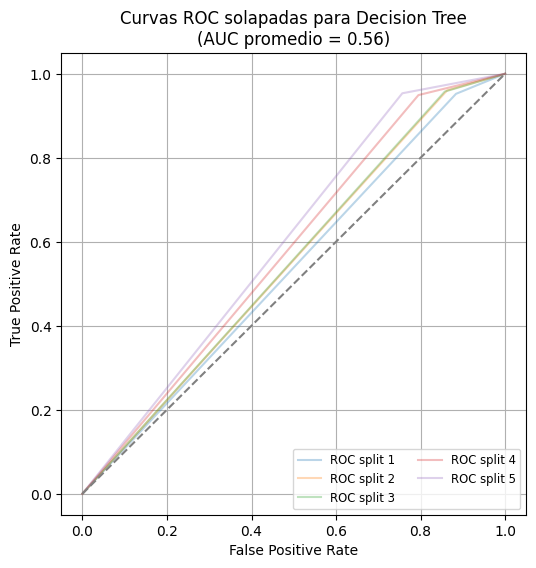

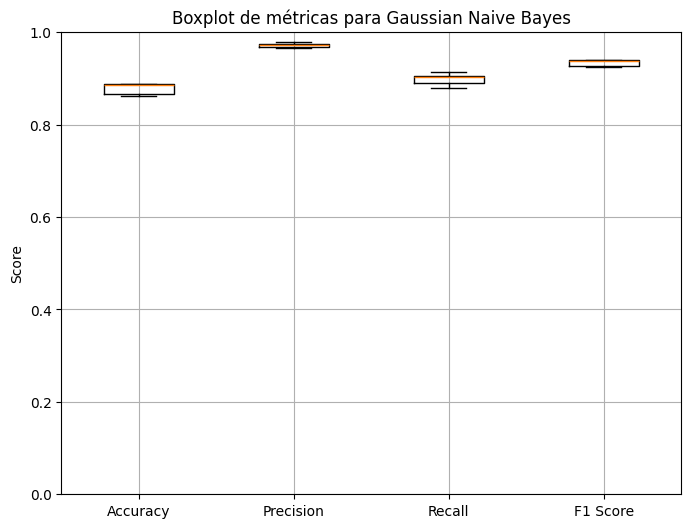

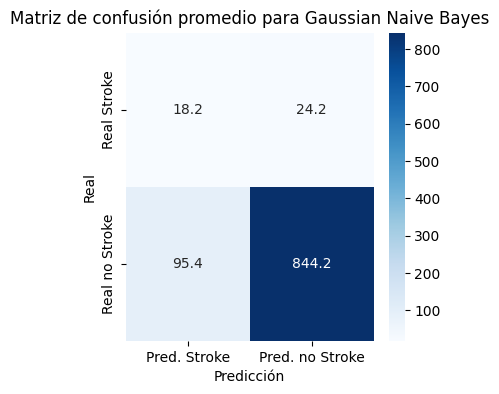

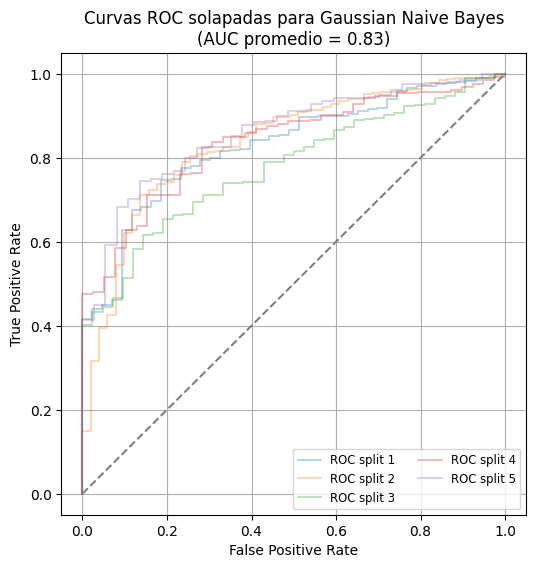

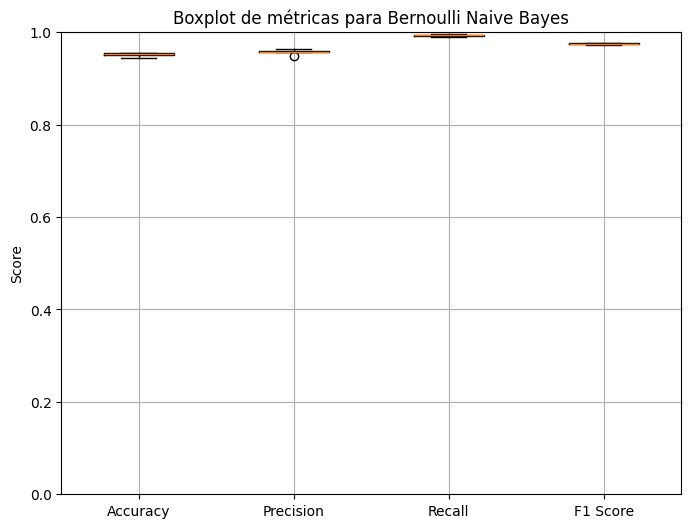

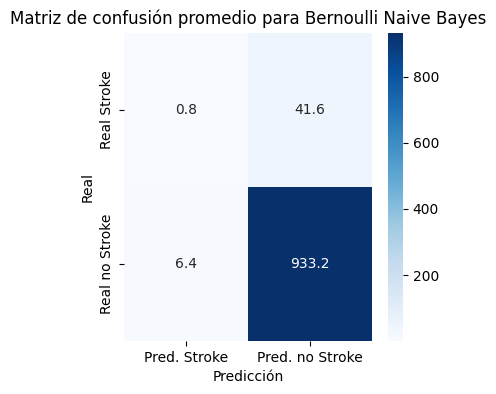

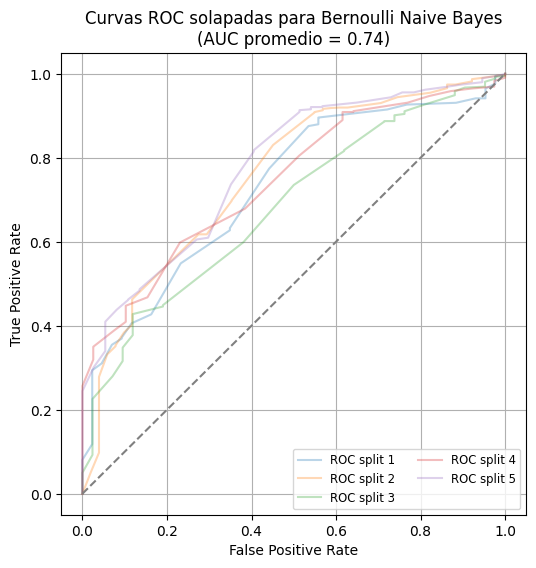

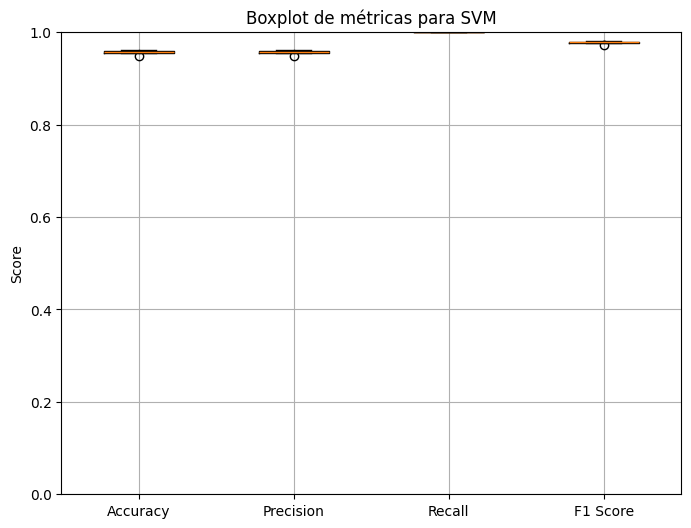

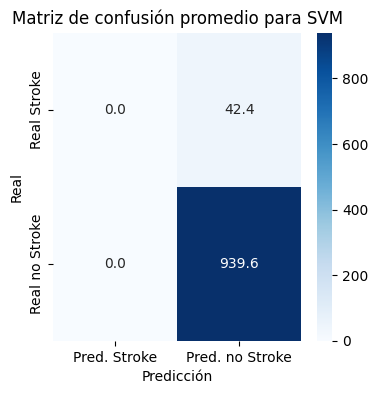

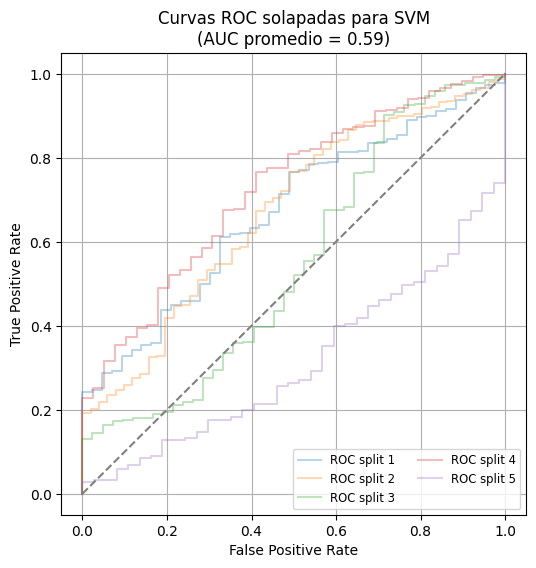

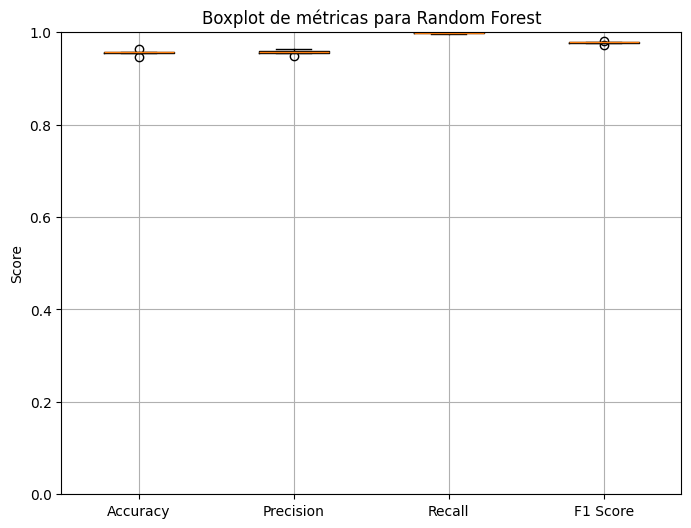

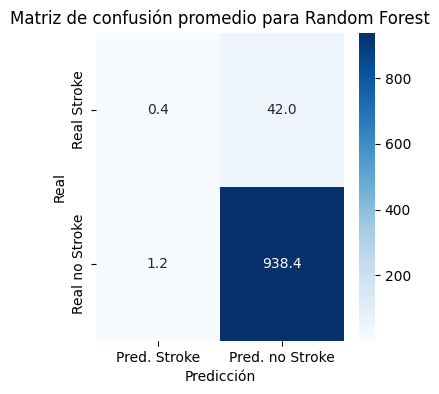

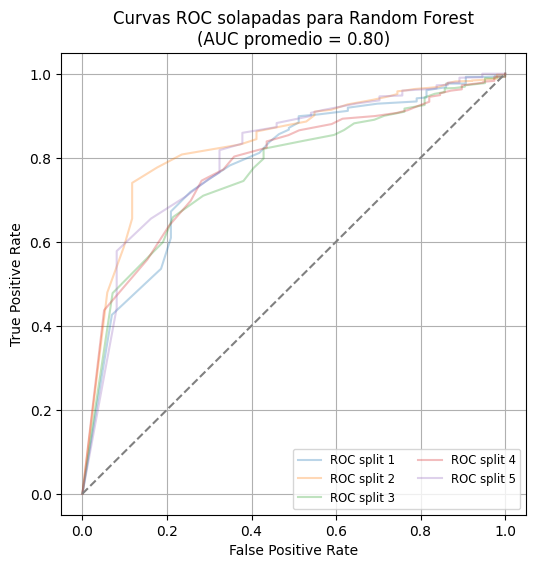

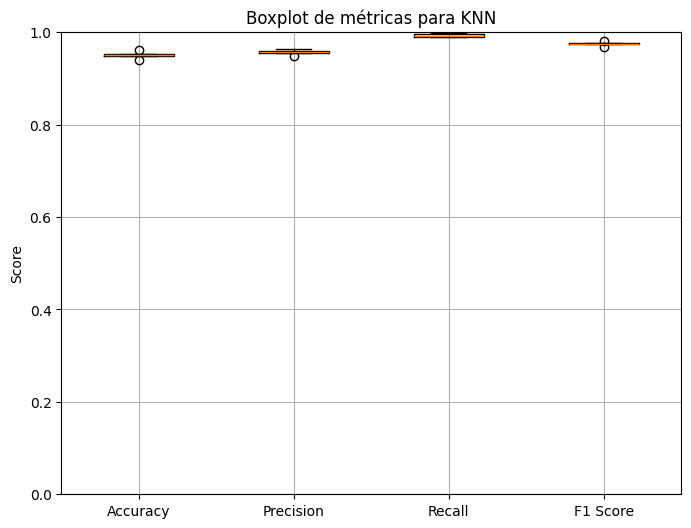

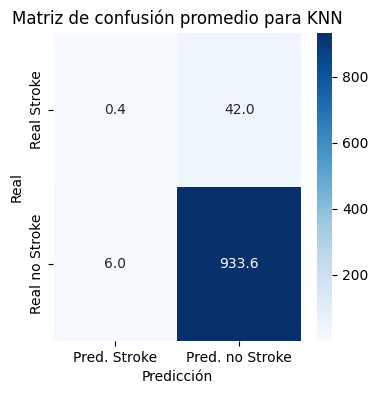

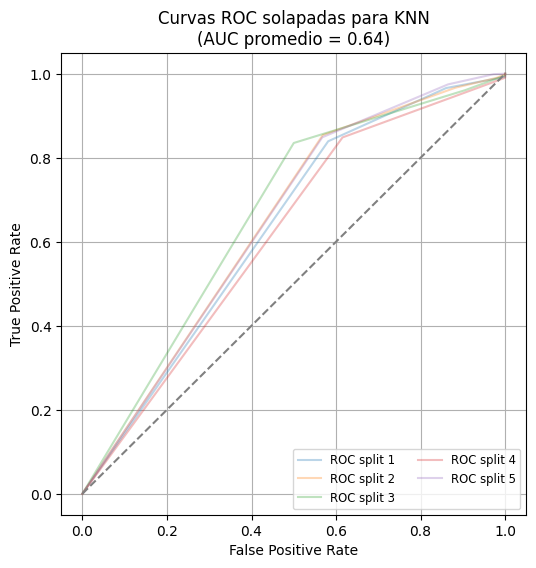

In [3]:
clean_dataset = formated_dataset.dropna()

x = clean_dataset.drop('stroke', axis=1)
y = clean_dataset['stroke']

results = entrenar(x, y)

graficar_resultados(results)

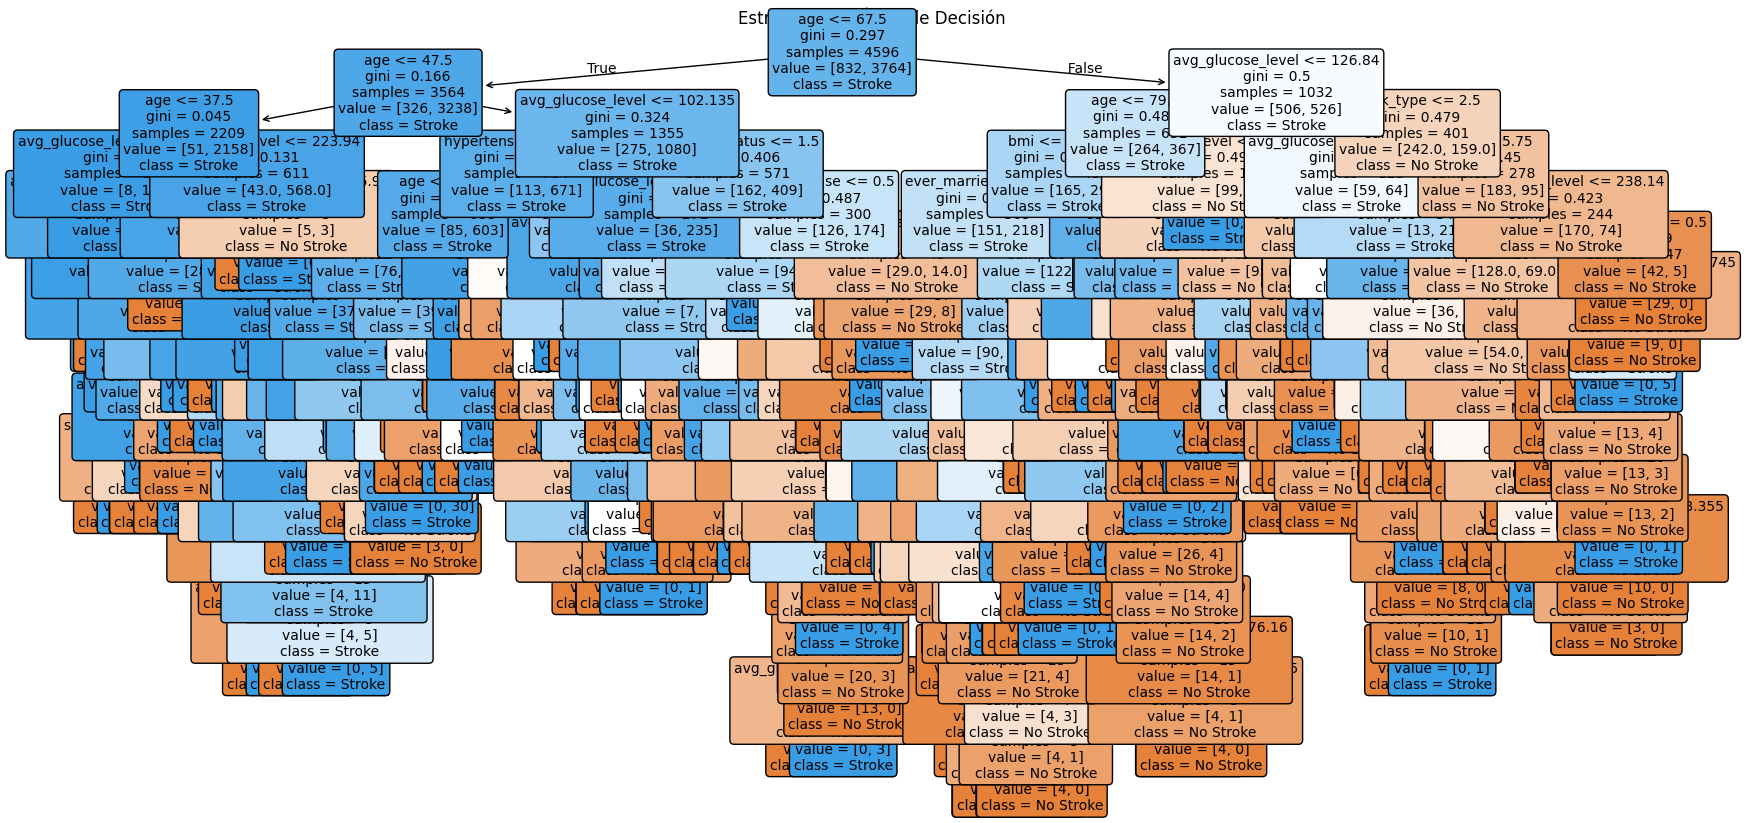

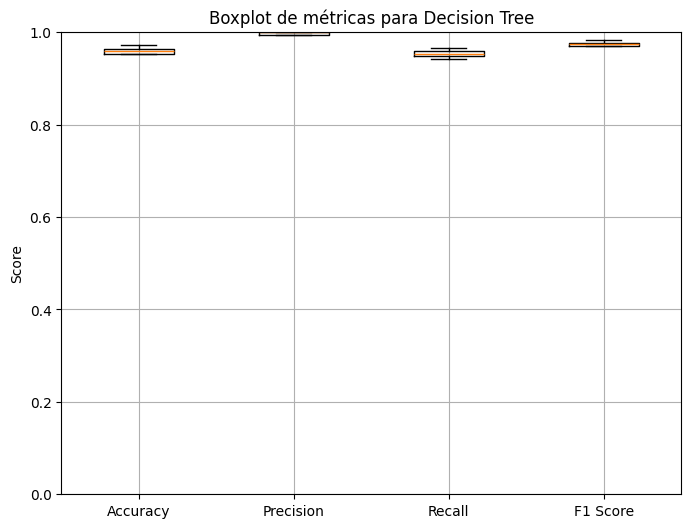

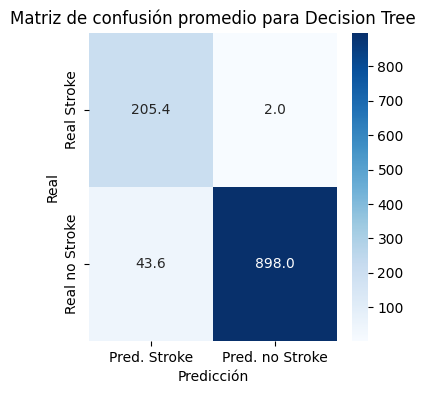

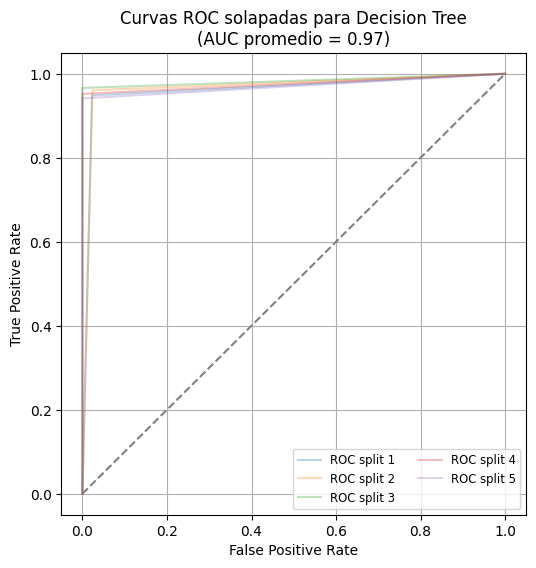

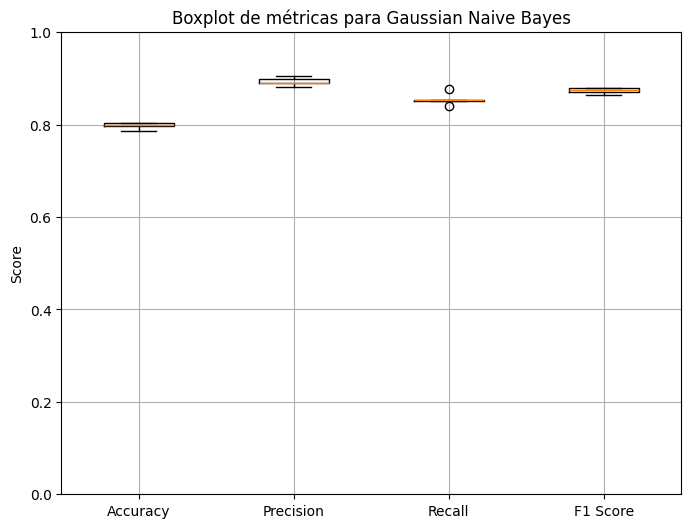

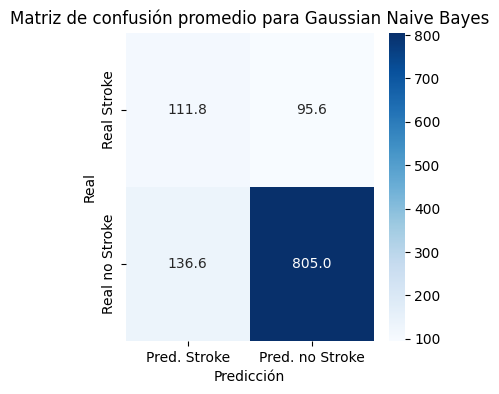

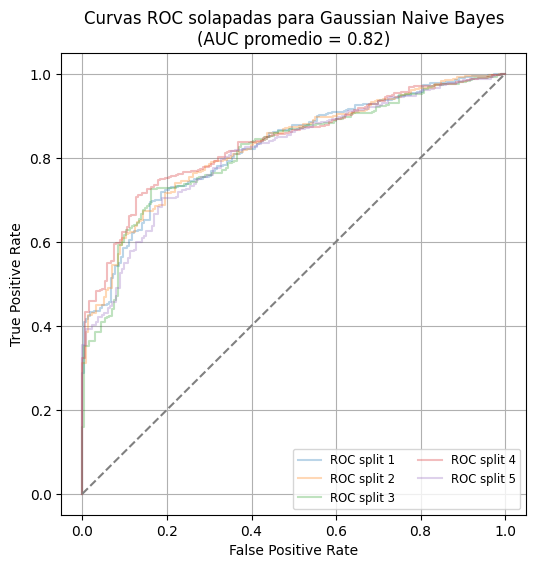

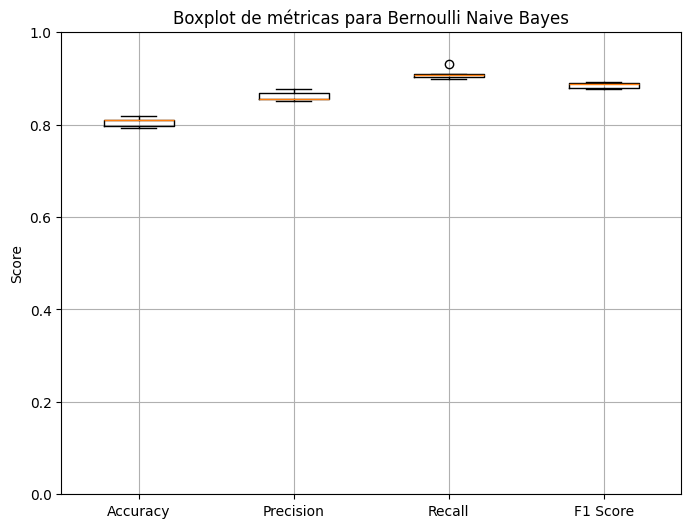

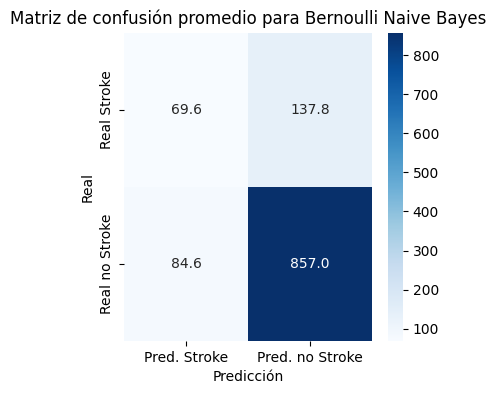

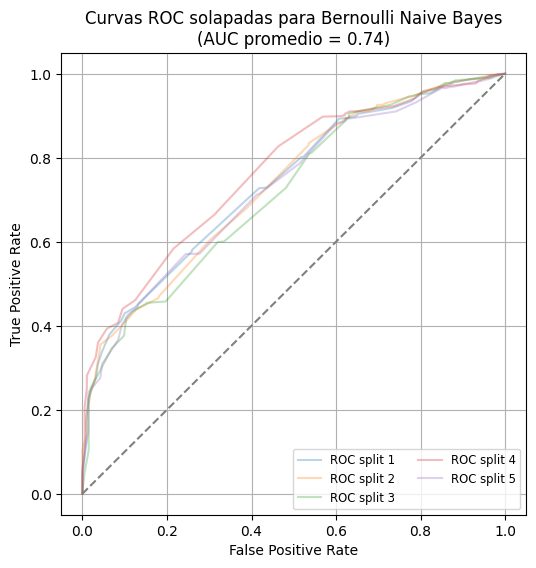

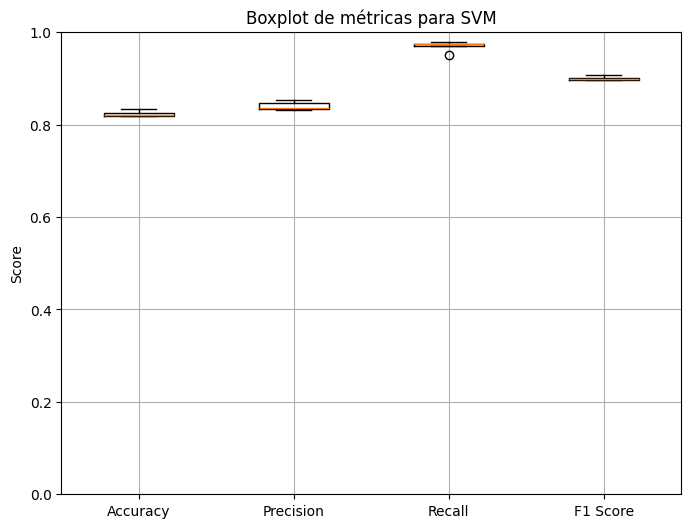

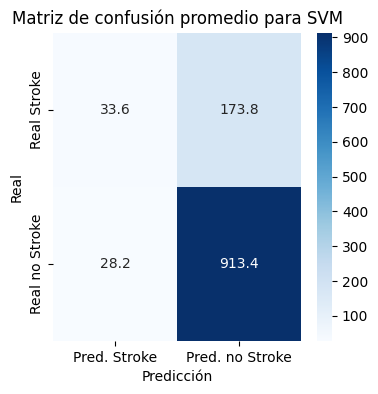

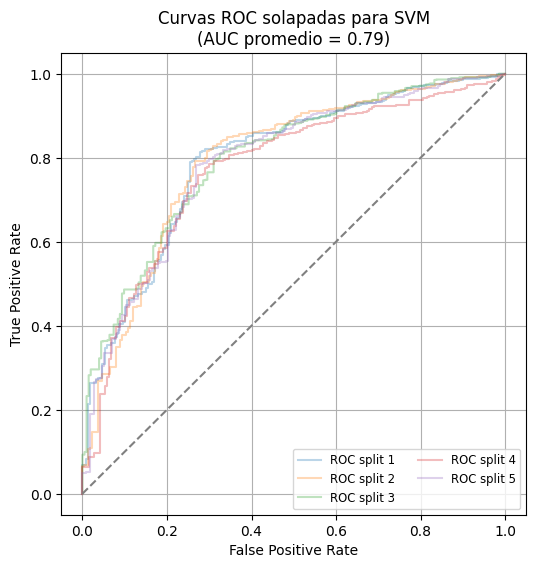

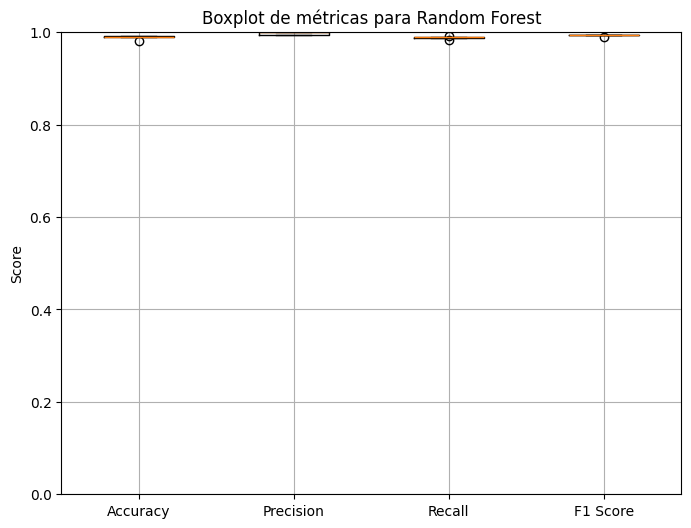

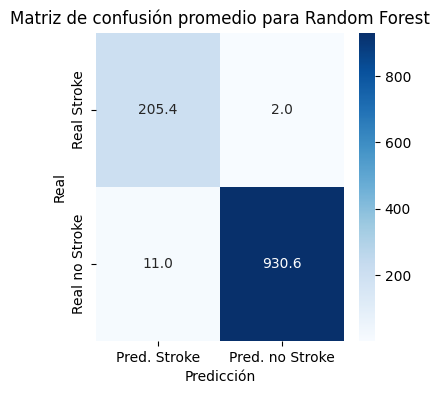

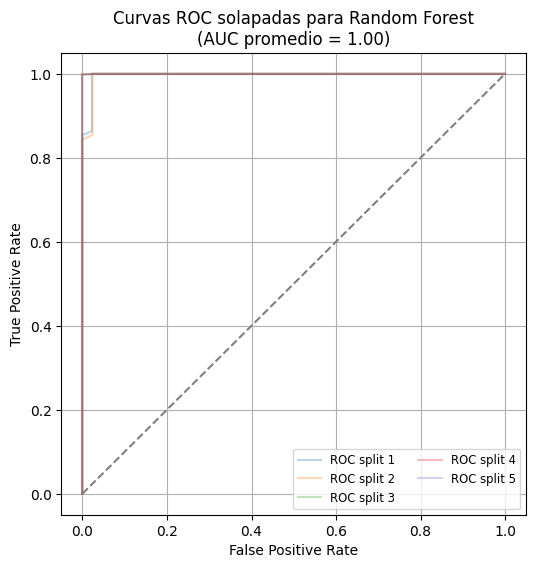

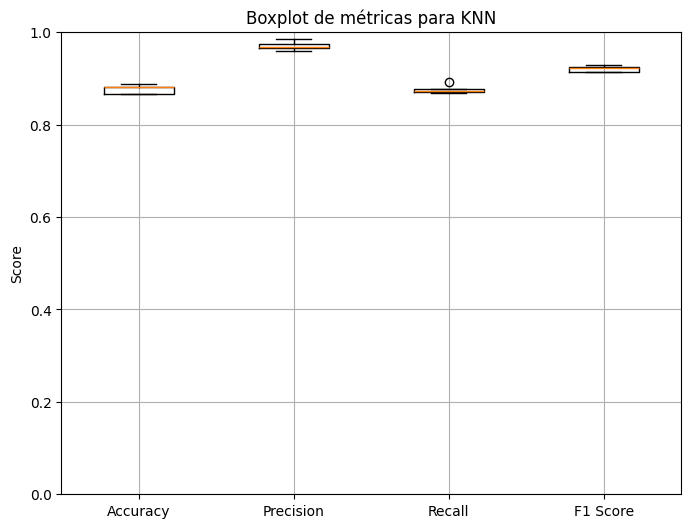

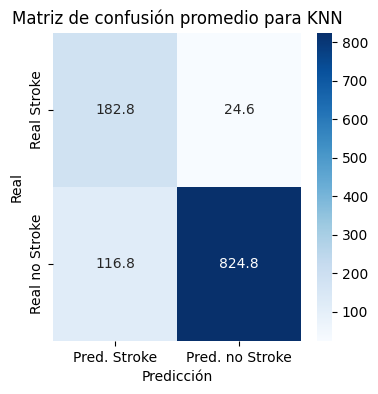

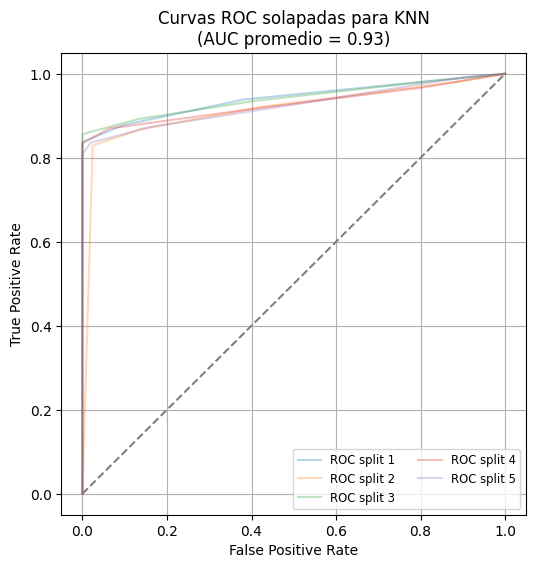

In [4]:
# Dividir el dataset en personas con y sin stroke
no_stroke_data = formated_dataset[formated_dataset['stroke'] == 1]
stroke_data = formated_dataset[formated_dataset['stroke'] == 0]

# Sobre-representar los datos de stroke (multiplicar por 22)
stroke_data_overrepresented = pd.concat([stroke_data] * 5, ignore_index=True)

# Combinar los datasets
balanced_dataset = pd.concat([stroke_data_overrepresented, no_stroke_data], ignore_index=True)

# Mezclar los datos para evitar orden
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

clean_dataset = balanced_dataset.dropna()


x = clean_dataset.drop('stroke', axis=1)
y = clean_dataset['stroke']

results = entrenar(x, y)

graficar_resultados(results)

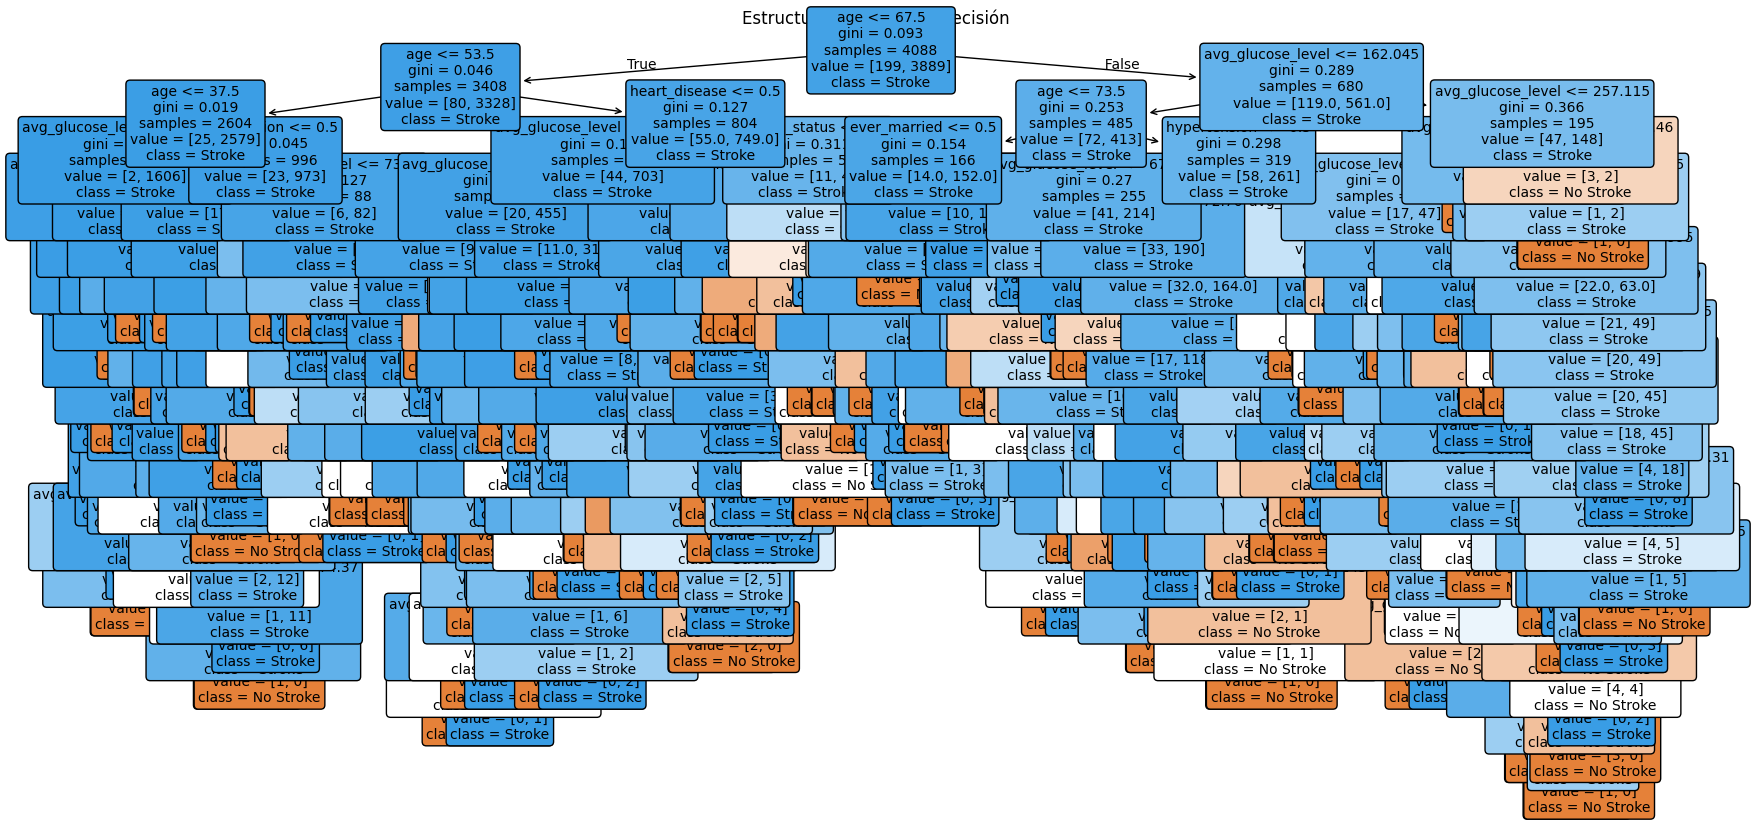

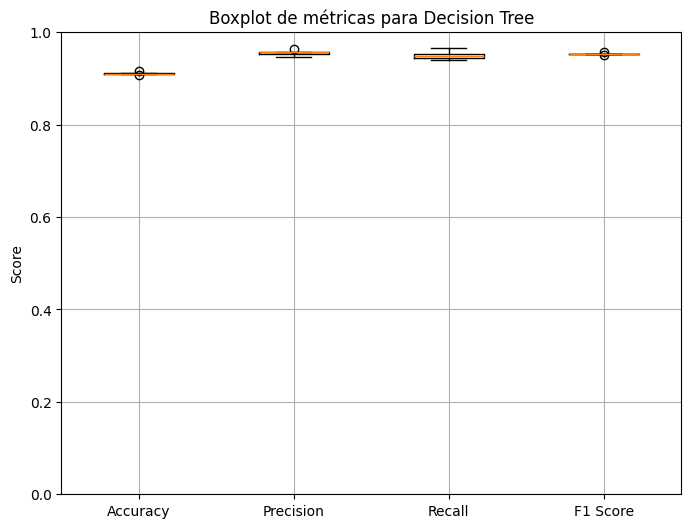

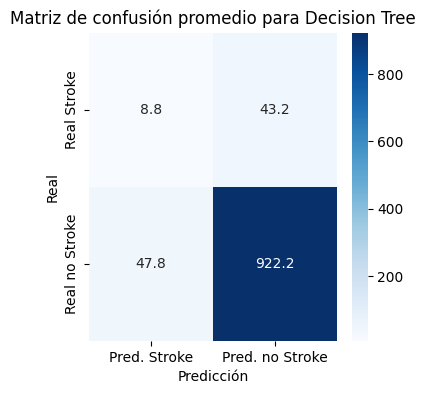

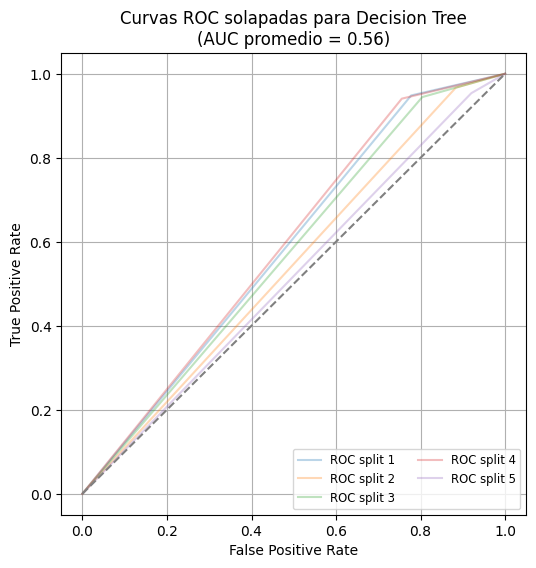

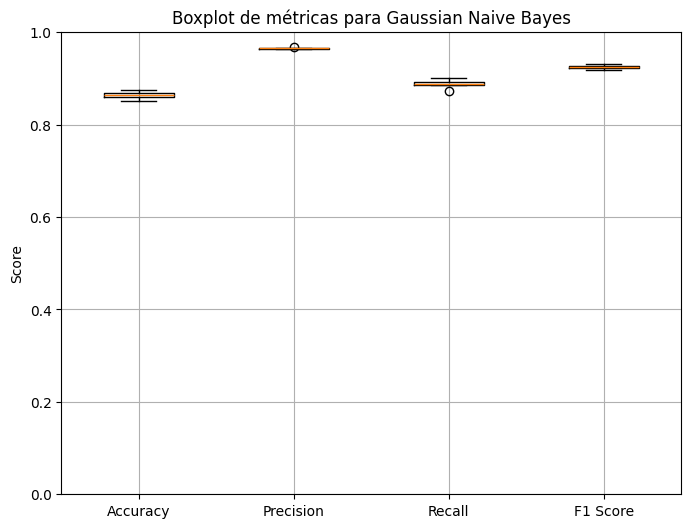

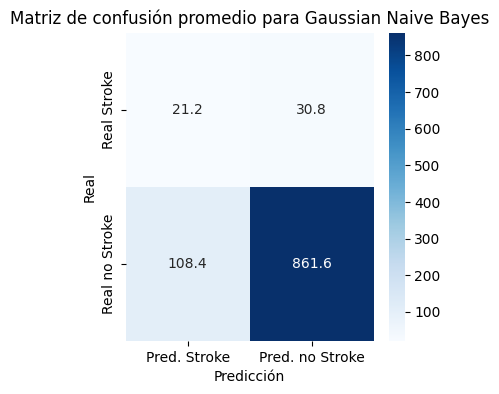

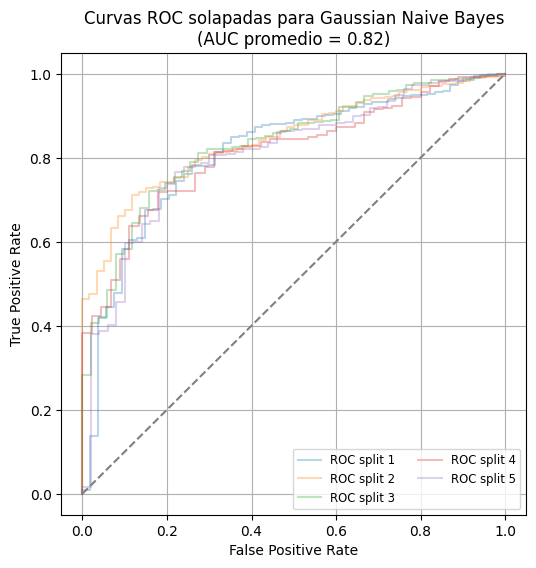

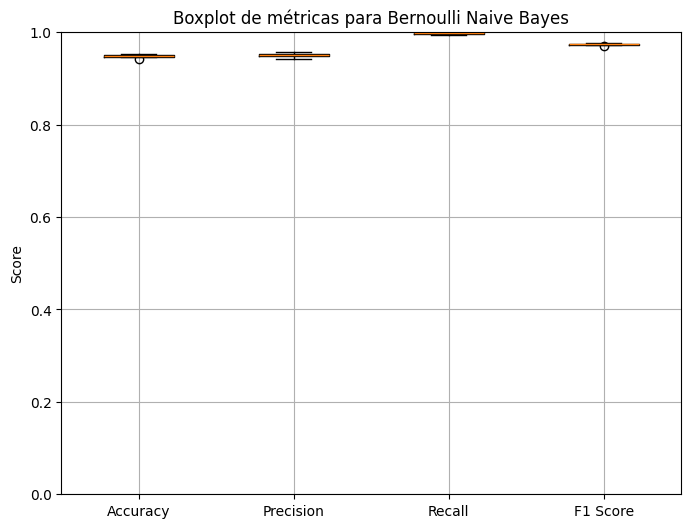

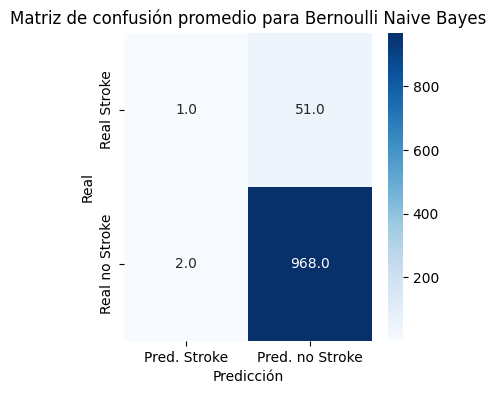

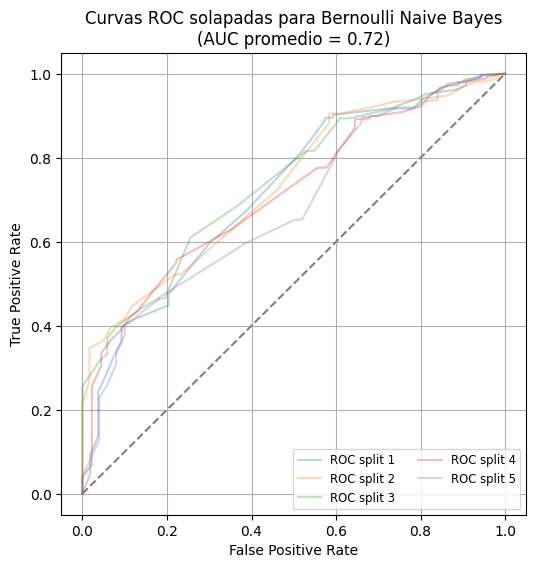

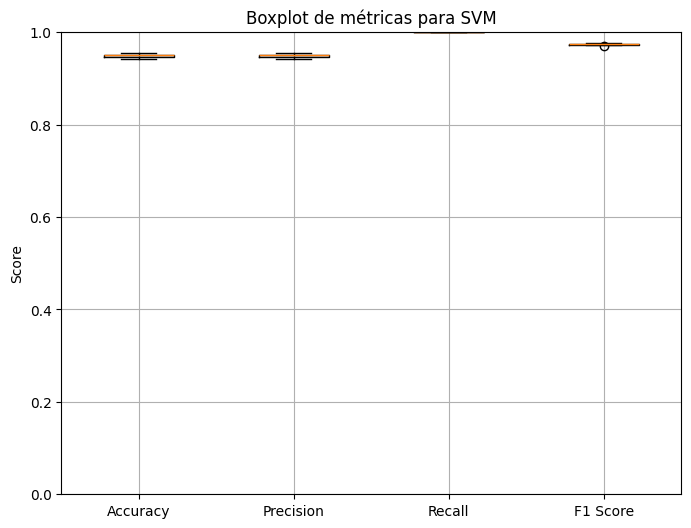

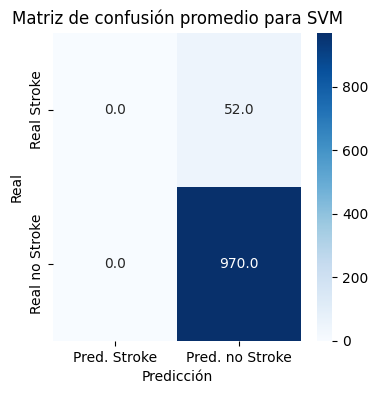

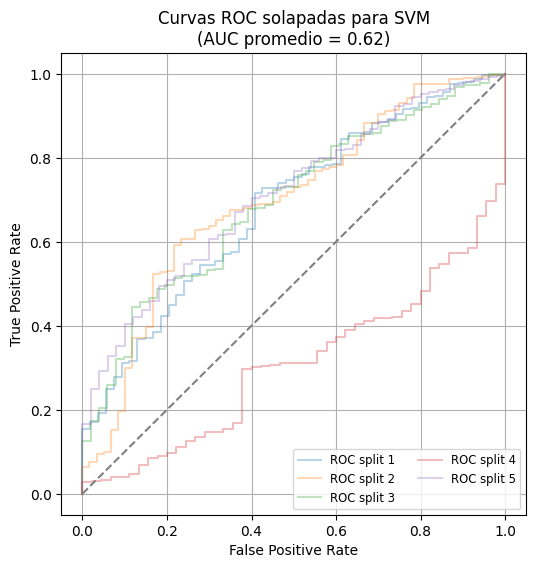

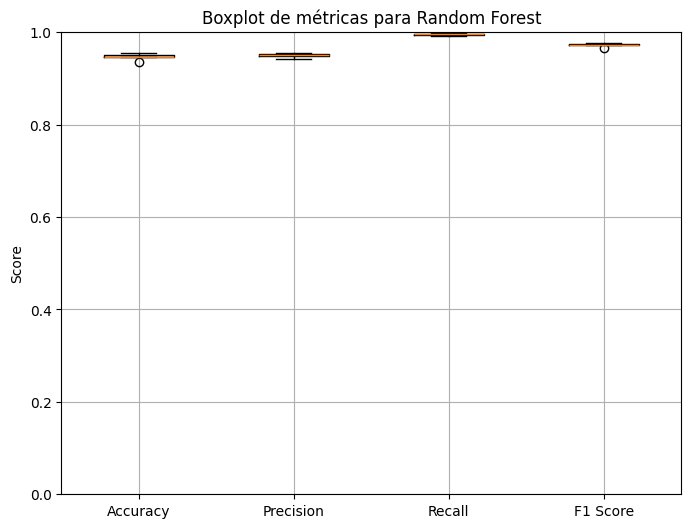

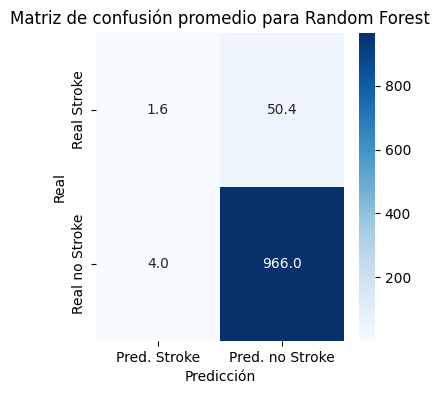

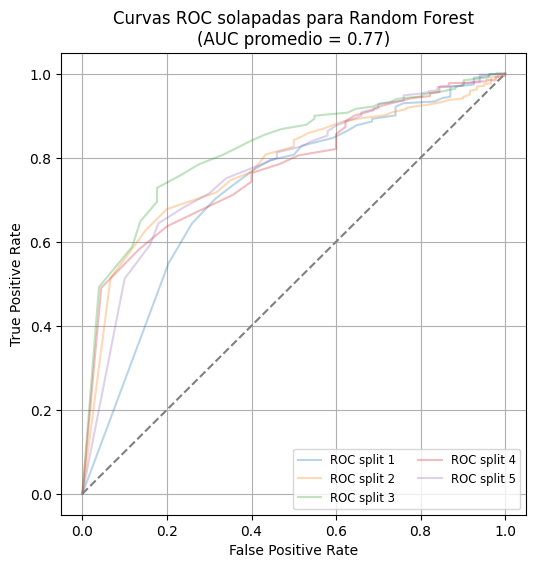

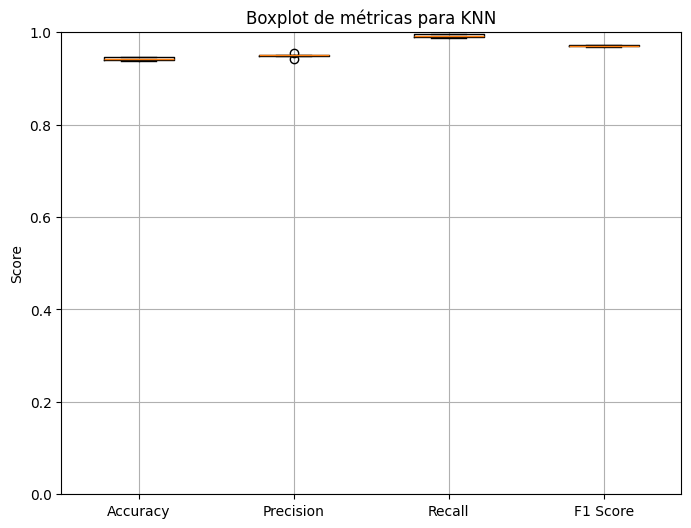

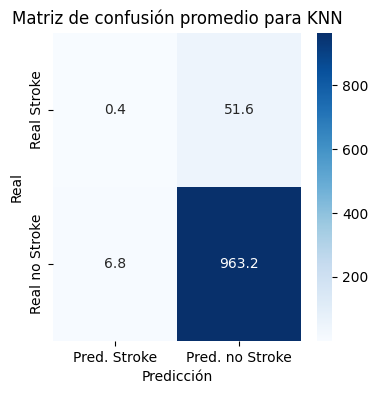

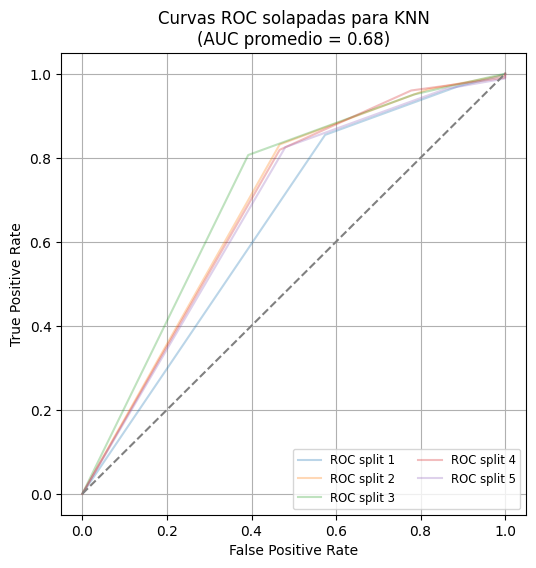

In [5]:
clean_dataset = formated_dataset.drop('bmi', axis=1)
clean_dataset = clean_dataset.dropna()


x = clean_dataset.drop('stroke', axis=1)
y = clean_dataset['stroke']

results = entrenar(x, y)

graficar_resultados(results)

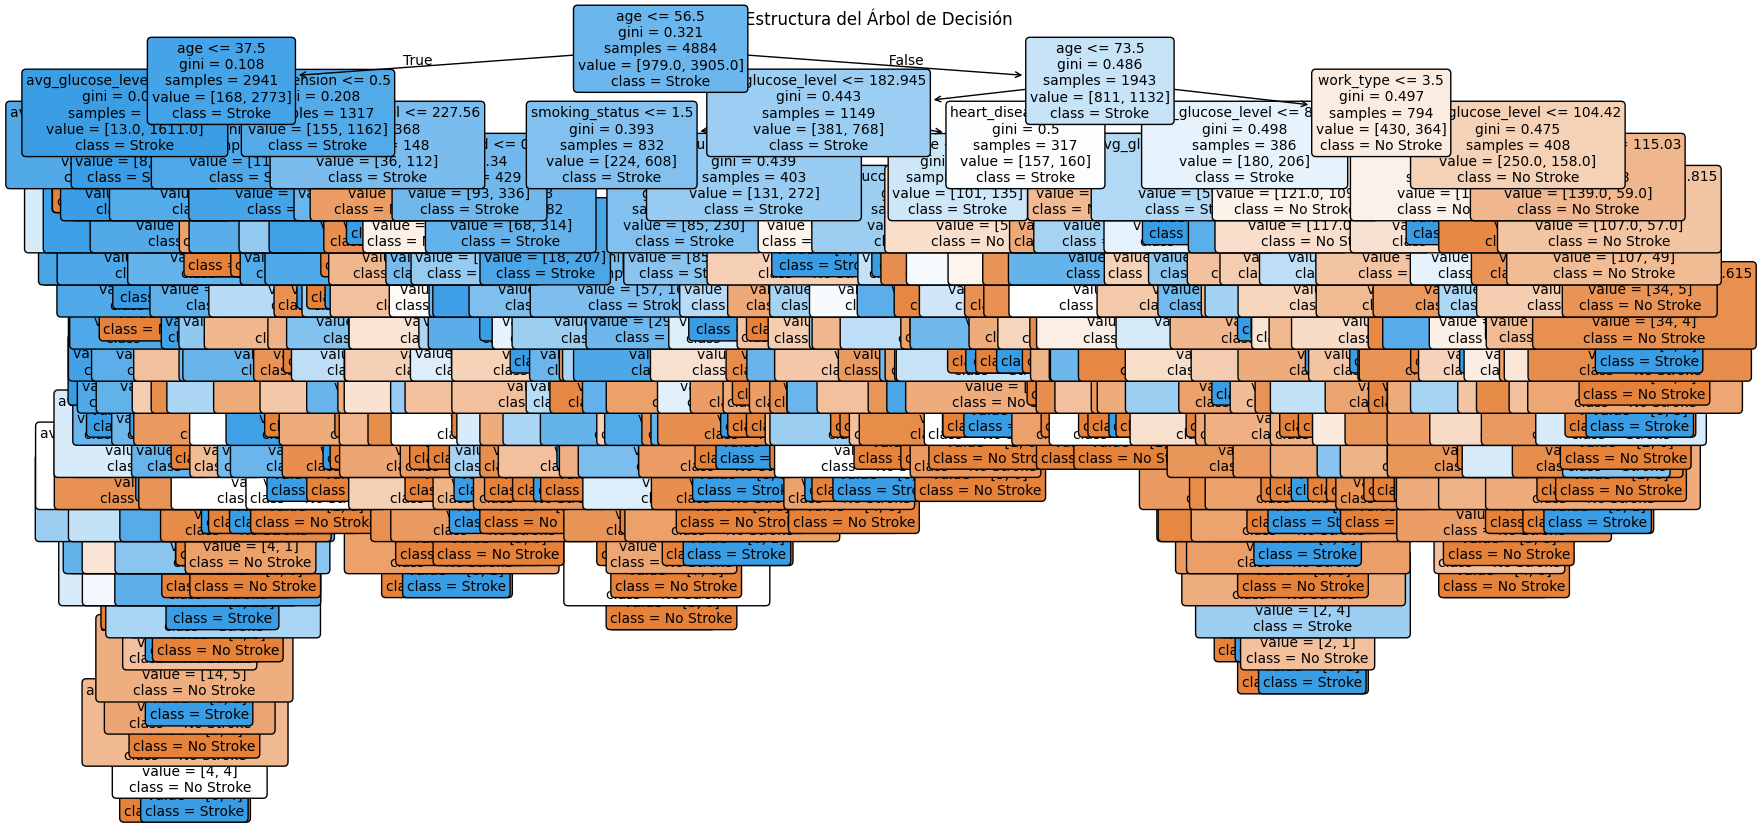

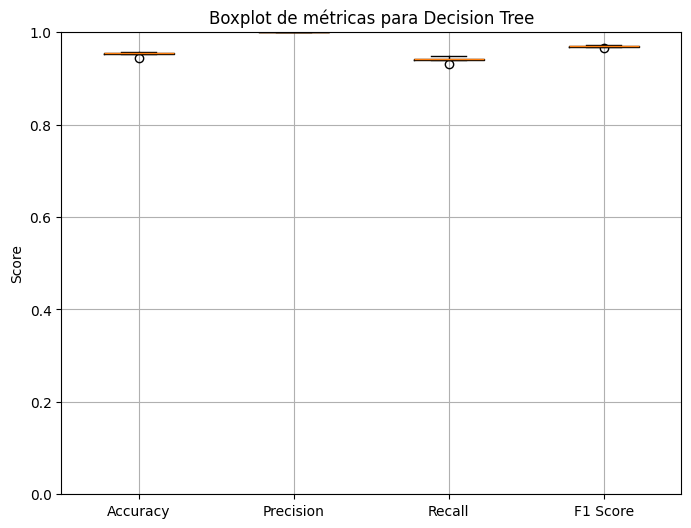

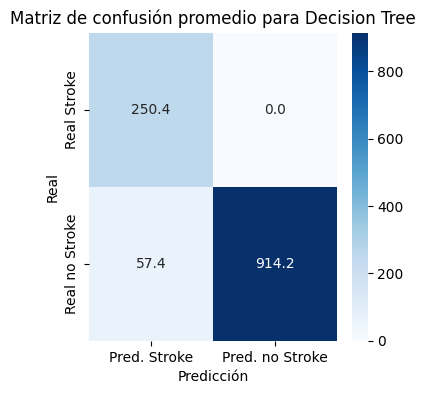

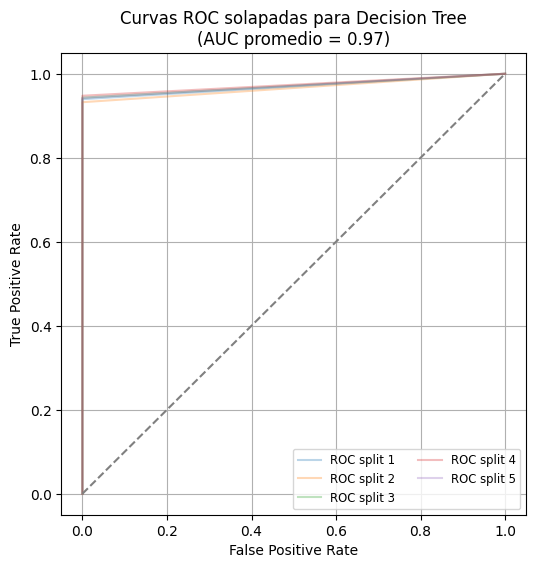

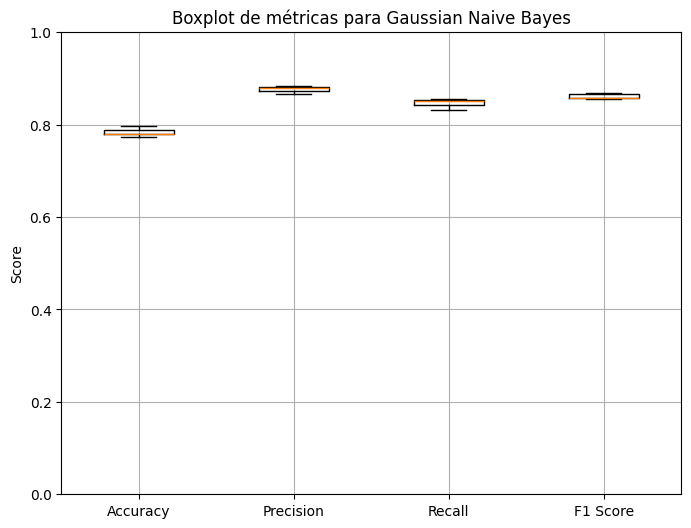

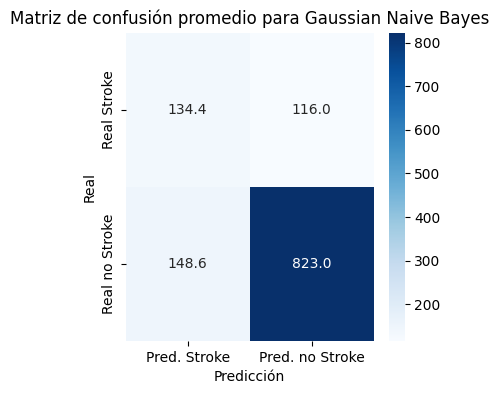

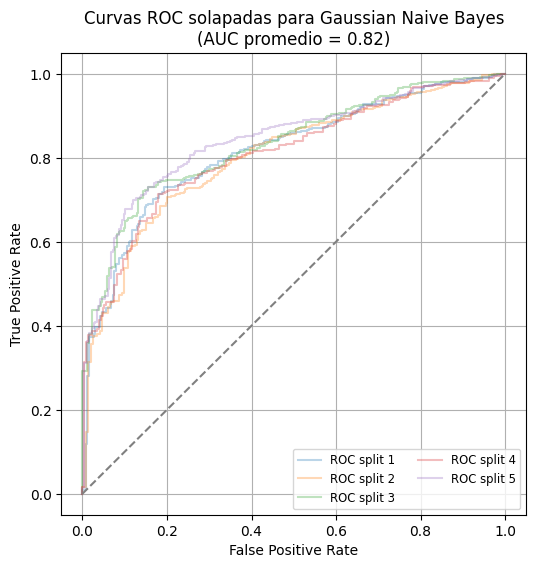

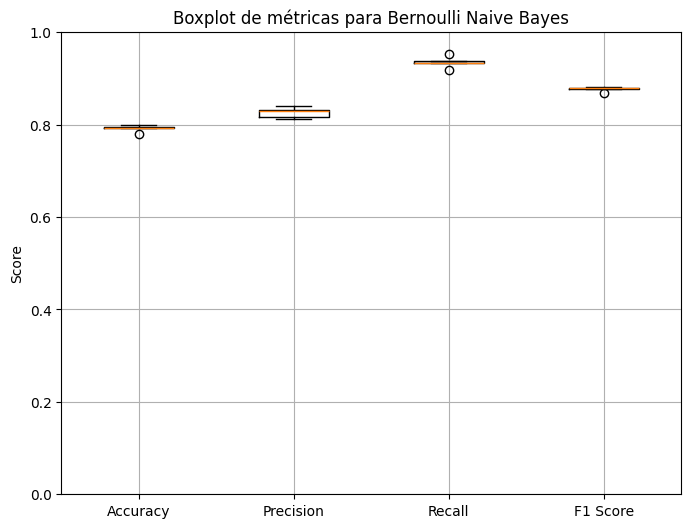

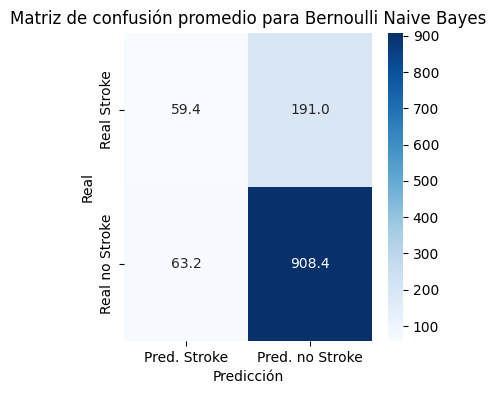

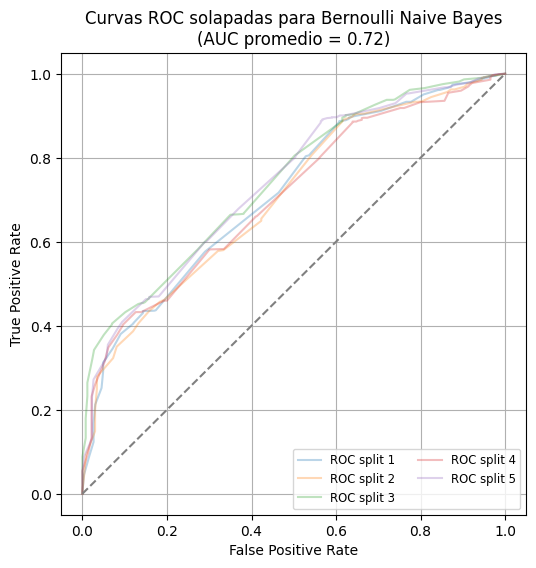

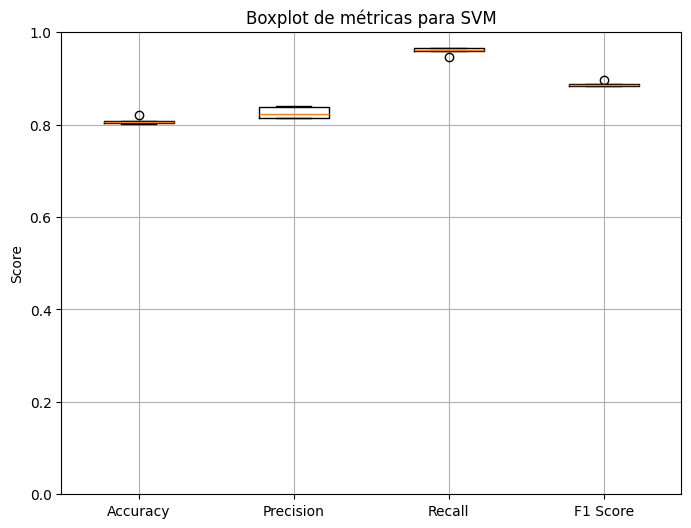

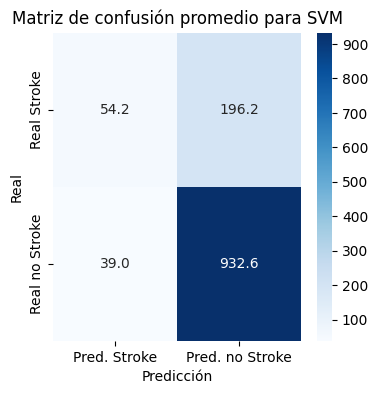

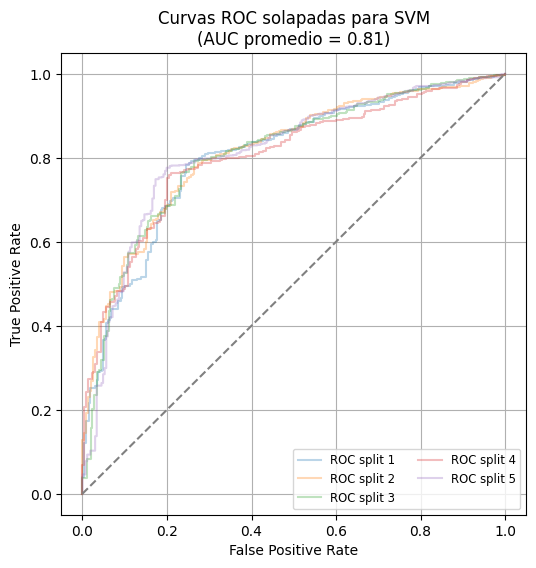

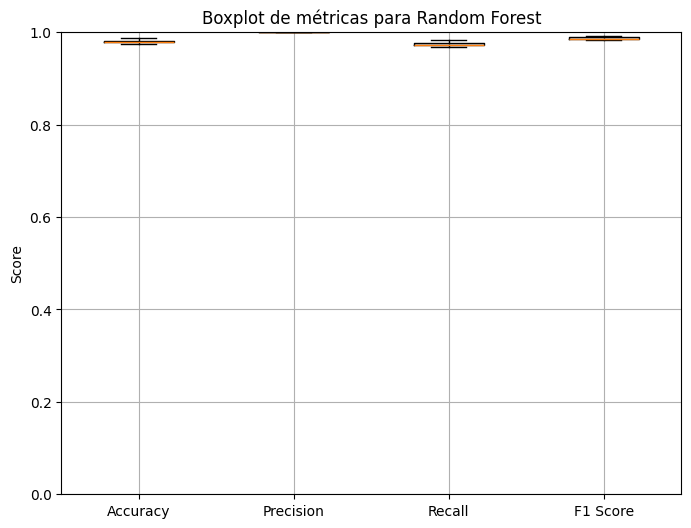

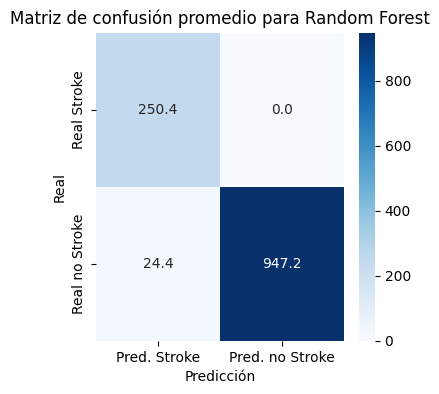

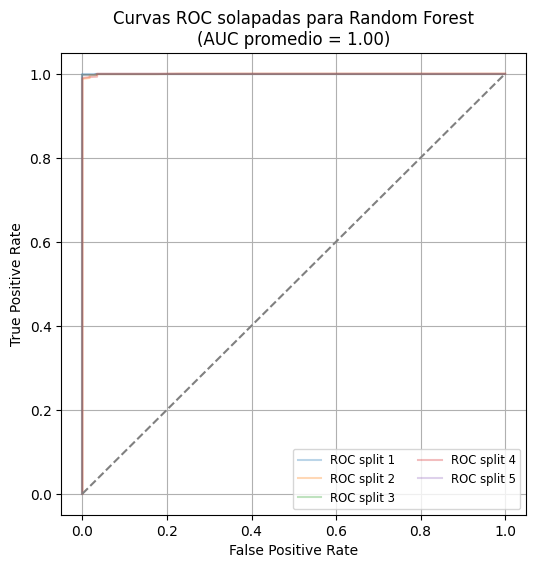

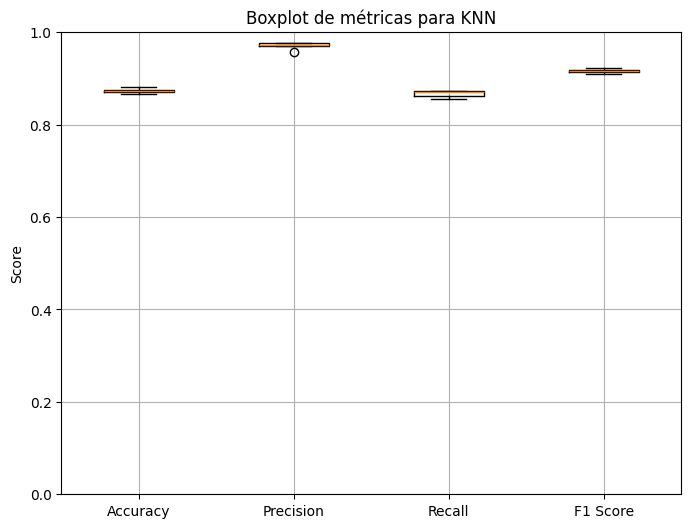

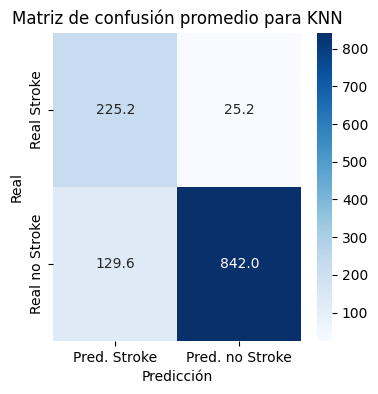

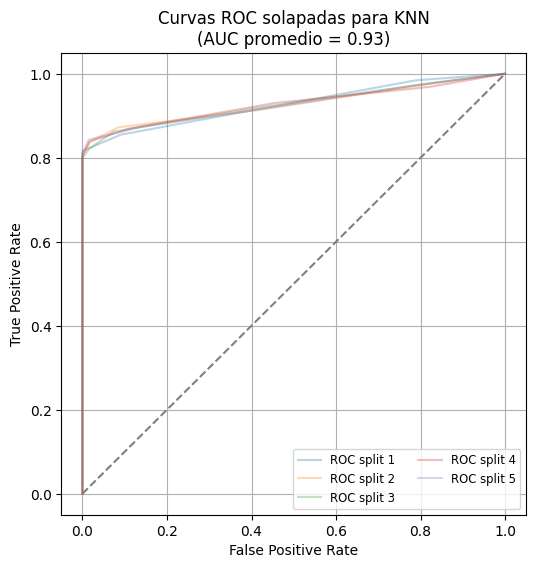

In [6]:
# Dividir el dataset en personas con y sin stroke
no_stroke_data = formated_dataset[formated_dataset['stroke'] == 1]
stroke_data = formated_dataset[formated_dataset['stroke'] == 0]

# Sobre-representar los datos de stroke (multiplicar por 5)
stroke_data_overrepresented = pd.concat([stroke_data] * 5, ignore_index=True)

# Combinar los datasets
balanced_dataset = pd.concat([stroke_data_overrepresented, no_stroke_data], ignore_index=True)

# Mezclar los datos para evitar orden
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

clean_dataset = balanced_dataset.drop('bmi', axis=1)
clean_dataset = clean_dataset.dropna()


x = clean_dataset.drop('stroke', axis=1)
y = clean_dataset['stroke']

results = entrenar(x, y)

graficar_resultados(results)